In [34]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


In [3]:
def linear_regression(df: pd.DataFrame) -> list[float]:
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df['clean_text'])
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    return clusters.tolist()

def activation_func(x: list[float]) -> list[float]:
    max_val = max(x) if max(x) != 0 else 1
    return [round(i / max_val, 2) for i in x]

def neuron(df: pd.DataFrame):
    temp_result = linear_regression(df)
    result = activation_func(temp_result)
    return result

In [23]:
def text_analysis(df):
    df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

    all_words = ' '.join(df['clean_text']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(df['text_length'], bins=30)
    plt.title('Распределение длины текстов')

    plt.subplot(2, 2, 2)
    words, counts = zip(*common_words)
    sns.barplot(x=list(counts), y=list(words))
    plt.title('Топ 20 самых частых слов')

    plt.subplot(2, 2, 3)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов')

    plt.tight_layout()
    plt.show()


In [28]:
def analyze_clusters(df):
    cluster_sizes = df['cluster'].value_counts().sort_index()

    cluster_stats = df.groupby('cluster').agg({
        'text_length': ['mean', 'median', 'count'],
    })

    vectorizer = TfidfVectorizer(max_features=5000)
    vectors = vectorizer.fit_transform(df['clean_text'])
    feature_names = vectorizer.get_feature_names_out()

    print("\nАнализ кластеров:")
    print("Размеры кластеров:")
    print(cluster_sizes)
    print("\nСтатистика по кластерам:")
    print(cluster_stats)

    kmeans = KMeans(n_clusters=5, random_state=42).fit(vectors)
    print("\nТоп слова по кластерам:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(5):
        print(f"\nКластер {i}:")
        top_words = [feature_names[ind] for ind in order_centroids[i, :10]]
        print(", ".join(top_words))

In [16]:
df = pd.read_csv('texts.csv')
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

In [17]:
df['clean_text'] = df['text'].apply(preprocess)

In [18]:
cluster_result = neuron(df)
df['cluster'] = cluster_result

In [19]:
df['label'] = df['category'].astype('category').cat.codes
ari = adjusted_rand_score(df['label'], df['cluster'])
print(f'Adjusted Rand Index: {ari:.3f}')

Adjusted Rand Index: 0.025


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [30]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'] if 'label' in df.columns else df['cluster']

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

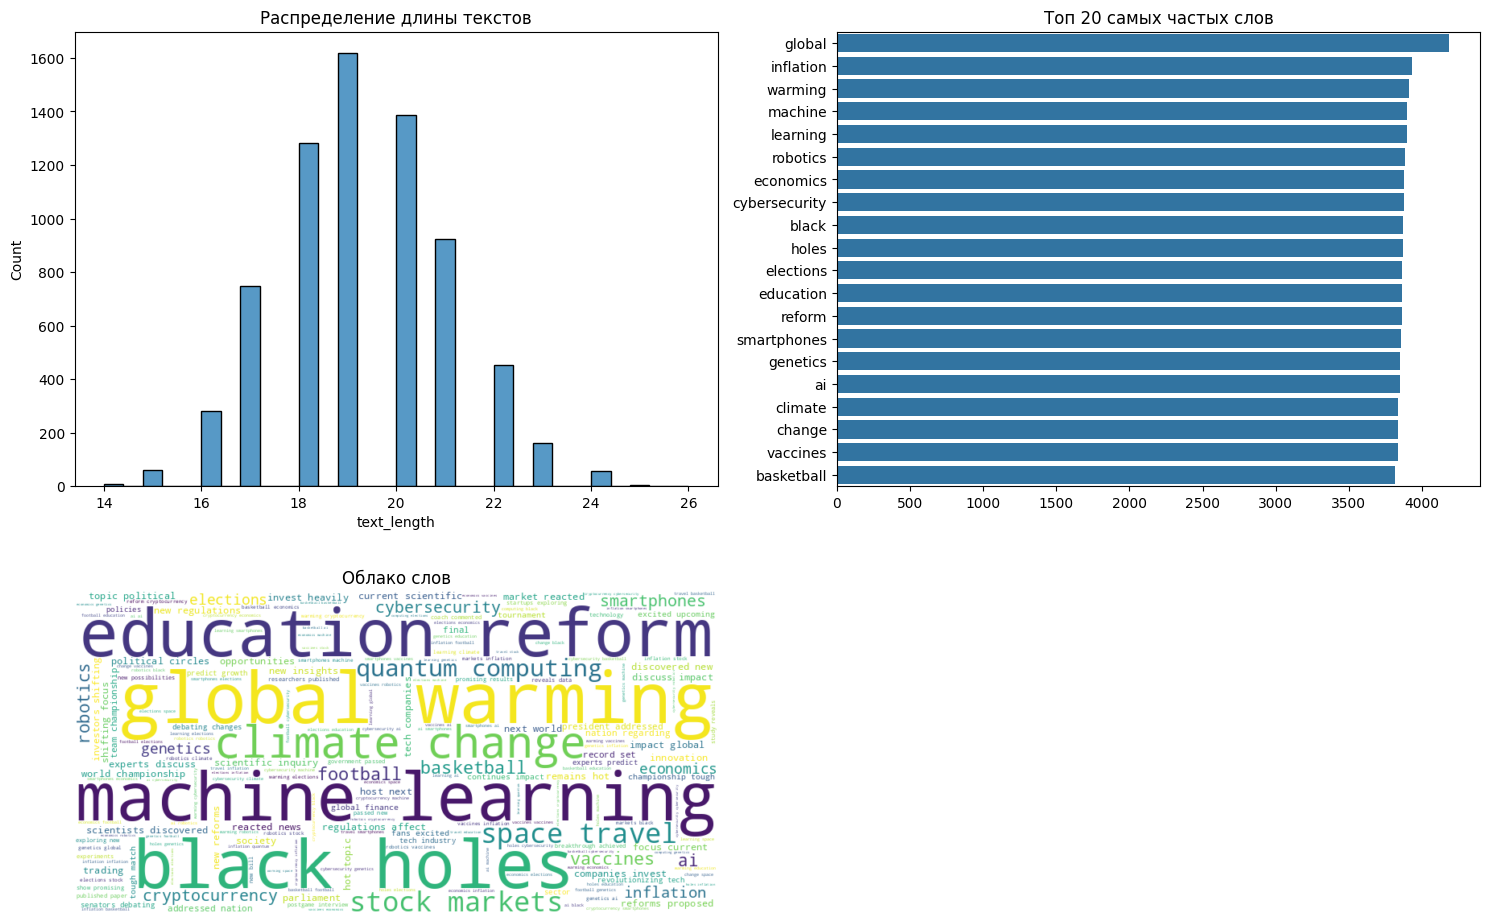

In [26]:
text_analysis(df)

In [29]:
analyze_clusters(df)


Анализ кластеров:
Размеры кластеров:
cluster
0.00     290
0.25    1779
0.50    2228
0.75     588
1.00    2105
Name: count, dtype: int64

Статистика по кластерам:
        text_length             
               mean median count
cluster                         
0.00      20.413793   20.0   290
0.25      19.538505   19.0  1779
0.50      18.547576   18.0  2228
0.75      19.329932   19.0   588
1.00      19.522090   19.0  2105

Топ слова по кластерам:

Кластер 0:
topic, remains, political, hot, circles, vaccines, smartphones, computing, quantum, elections

Кластер 1:
change, climate, global, robotics, elections, inflation, warming, cybersecurity, ai, basketball

Кластер 2:
genetics, smartphones, vaccines, global, football, economics, ai, learning, machine, space

Кластер 3:
focus, shifting, opportunities, investors, inquiry, current, scientific, economics, cryptocurrency, ai

Кластер 4:
black, holes, inflation, cryptocurrency, elections, genetics, stock, markets, global, robotics


In [31]:
print(f'\nРазмеры выборок:')
print(f'Обучающая выборка: {X_train.shape[0]}')
print(f'Валидационная выборка: {X_val.shape[0]}')
print(f'Тестовая выборка: {X_test.shape[0]}')


Размеры выборок:
Обучающая выборка: 4893
Валидационная выборка: 1048
Тестовая выборка: 1049


In [32]:
def find_optimal_clusters(X, max_k=10):
    distortions = []
    silhouettes = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k+1), distortions, marker='o')
    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Сумма квадратов расстояний')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k+1), silhouettes, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()


Анализ оптимального количества кластеров:


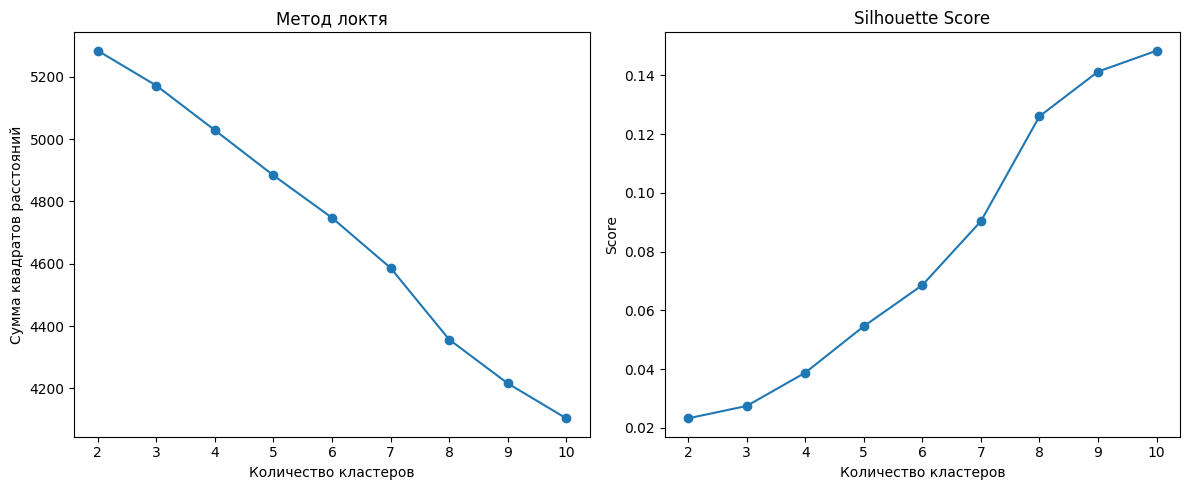

In [35]:
print("\nАнализ оптимального количества кластеров:")
find_optimal_clusters(X)